# Problem 9

### Authors: Miguel Ferrer and Andy Kim
### SUNet ID: mferrera, jkim4223

In [1]:
# Import CVX and numpy libraries
import cvxpy as cvx
import numpy as np
import random

# SOCP.

First, we set up our problem. Points $a_i$ with $1 \leq i \leq 3$ represent the anchor points. We need to generate points located inside the convex hull defined by these anchor points. We construct a method to solve the SOCP problem for any given two points, with the anchors set according to the problem statement.

In [34]:
def generate(n,npoints):
    # Set the limits
    origA = np.full((n+1,n),-5.)
    rangA = np.full((n+1,n), 10.)
    origP = np.full((npoints,n),-5.)
    rangP = np.full((npoints,n), 10.)

    # Construct the anchor points
    a = np.random.rand(n+1,n)
    a = origA + np.multiply(a,rangA)

    # Construct the sensor points
    p = np.random.rand(npoints,n)
    p = origP + np.multiply(p,rangP)

    adjacency = np.full((npoints+n+1,npoints+n+1),-1.)

    if(n > 1):
        minConstr = 3
        maxConstr = 4
        minPointConstr = 2
        minAnchConstr = 1
    else:
        minConstr = 2
        maxConstr = 3
        minPointConstr = 1
        minAnchConstr = 1

    anchList = [i for i in range(n+1)]
    pointList = [i for i in range(npoints)]
    off = n + 1

    for i in range(npoints):
        random.shuffle(anchList)
        random.shuffle(pointList)
        # Set anchor constraints, between 1 and 3
        numAnch = random.randint(minAnchConstr,minConstr)
        for l in range(numAnch):
            adjacency[anchList[l],i+off] = np.linalg.norm(a[anchList[l]] - p[i])
            adjacency[i+off,anchList[l]] = adjacency[anchList[l],i+off]
        print(numAnch)
        # Count number of constraints already set for this point
        countConstr = 0
        for l in range(npoints+off):
            if(adjacency[l,i+off] > 0):
                countConstr = countConstr + 1
        # Set point constraints, between 0 and 3
        if(minConstr - countConstr >= 0):
            numPoint = random.randint(minConstr-countConstr,3)
            count = numPoint
            l = 0
            while(count > 0 and l < len(pointList)):
                if(pointList[l] != i):
                        countConstr = 0
                        for k in range(npoints+off):
                            if(adjacency[k,pointList[l]+off] > 0):
                                countConstr = countConstr + 1
                        if(countConstr < maxConstr):
                            adjacency[pointList[l]+off,i+off] = np.linalg.norm(p[pointList[l]] - p[i])
                            adjacency[i+off,pointList[l]+off] = adjacency[pointList[l]+off,i+off]
                            count = count - 1
                l = l + 1
    return [a, p, adjacency]

In [35]:
n = 2
npoints = 2
[a,p,adjacency]=generate(n,npoints)

2
3


Populating the interactive namespace from numpy and matplotlib


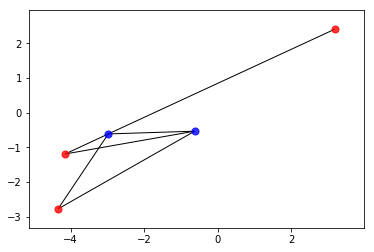

In [36]:
import matplotlib.pyplot as plt
import networkx as nx
%pylab inline --no-import-all
if(n == 2):
    G=nx.Graph()

    for i in range(n+1):
        G.add_node(i,pos=a[i])

    for i in range(npoints):
        G.add_node(n+1+i,pos=p[i])

    pos=nx.get_node_attributes(G,'pos')

    nx.draw_networkx_nodes(G,pos,
                           nodelist=[i for i in range(n+1)],
                           node_color='r',
                           node_size=100,
                           alpha=0.8,
                           with_labels=True)
    nx.draw_networkx_nodes(G,pos,
                           nodelist=[i for i in range(n+1,npoints+n+1)],
                           node_color='b',
                           node_size=100,
                           alpha=0.8,
                           with_labels=True)
    for i in range(npoints+n+1):
        for j in range(n+1,npoints+n+1):
            if(adjacency[j,i] > 0.):
                G.add_edge(i,j)

    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos,font_color='w',font_size=8,font_weight='bold')
    plt.draw()  # pyplot draw()

Now we can construct the different points $p_1$ and $p_2$. By solving the optimization problem, we want to find a good approximation of $p_1$, $p_2$.

### Both points inside the convex hull: strongly localizable

In [ ]:
# Construct our points
p1 = np.array([-0.4, 0.2])
p2 = np.array([0.0, 1.7])
solveForTwoPoints(p1,p2)

Reason: the set of $a_1$, $a_2$ and $x_2$ form a convex hull for which we know the distances to $x_1$, so we can solve to find $x_1$ as we did in problem 9 for Homework 1. Similarly, the set of $a_2$, $a_3$ and $x_1$ form a convex hull for which we know the distances to $x_2$, so we can find it in a similar fashion.

### Both points inside the convex hull: weakly localizable

In [ ]:
# Construct our points
p1 = np.array([0.0, 1.3])
p2 = np.array([0.6, 0.2])
solveForTwoPoints(p1,p2)

Reason:

### One point inside the convex hull

In [ ]:
# Construct our points
p1 = np.array([0.0, 0.8])
p2 = np.array([3.0, 5.0])
solveForTwoPoints(p1,p2)

Reason:

### Both points outside the convex hull

In [ ]:
# Construct our points
p1 = np.array([-0.5, -.8])
p2 = np.array([3.0, 5.0])
solveForTwoPoints(p1,p2)

Reason:

# SDP.

In [ ]:
def solveForTwoPointsSPD(p1, p2):
    # We are working in R^2
    n = 2
    
    # Construct the anchor points
    a1 = np.array([1.0, 0.0])
    a2 = np.array([-1.0, 0.0])
    a3 = np.array([0.0, 2.0])
    
    # Compute the Euclidian distances to the anchor points
    d11 = np.linalg.norm(p1 - a1)
    d12 = np.linalg.norm(p1 - a2)
    d22 = np.linalg.norm(p2 - a2)
    d23 = np.linalg.norm(p2 - a3)
    dbar12 = np.linalg.norm(p1 - p2)

    #This creates a 3x3 semipositive definite matrix which we will 
    #use as part of our constraints
    z = cvx.Semidef(T)

    #These outer products represent the four fixed matrices in the constraints
    constraint1 = np.outer(np.array([1., 0., 0., 0.]), np.array([1., 0., 0., 0.]))
    constraint2 = np.outer(np.array([0., 1., 0., 0.]), np.array([0., 1., 0., 0.]))
    constraint3 = np.outer(np.array([1., 1., 0., 0.]), np.array([1., 1., 0., 0.]))
    constraint4 = [np.outer(np.append(a1, [-1., 0.]), np.append(a1, [-1., 0.])), \
                   np.outer(np.append(a2, [-1., 0.]), np.append(a2, [-1., 0.])), \
                   np.outer(np.append(a2, [0., -1.]), np.append(a2, [0., -1.])), \
                   np.outer(np.append(a3, [0., -1.]), np.append(a3, [0., -1.]))]
    constraint5 = np.outer(np.array([0., 0., 1., -1.]),np.array([0., 0., 1., -1.]))

    #Another empty states list
    states = []

    cost = cvx.norm(0)
    
    #The four constraints in the SDP relaxation problem
    #Note that the last constraint forces z to be SPD
    constr = [cvx.sum_entries(cvx.mul_elemwise(constraint1, z)) == 1, \
              cvx.sum_entries(cvx.mul_elemwise(constraint2, z)) == 1, \
              cvx.sum_entries(cvx.mul_elemwise(constraint3, z)) == 2, \
              cvx.sum_entries(cvx.mul_elemwise(constraint4[0], z)) == d11 ** 2, \
              cvx.sum_entries(cvx.mul_elemwise(constraint4[1], z)) == d12 ** 2, \
              cvx.sum_entries(cvx.mul_elemwise(constraint4[2], z)) == d22 ** 2, \
              cvx.sum_entries(cvx.mul_elemwise(constraint4[3], z)) == d23 ** 2, \
              cvx.sum_entries(cvx.mul_elemwise(constraint5, z)) == dbar12 ** 2, \
              (z >> 0)]
    
    #Add the constraints and cost function
    states.append(cvx.Problem(cvx.Minimize(cost), constr))
    
    #Solve the SDP relaxation problem
    prob = sum(states)
    prob.solve();    

    print('Solution: ' + prob.status)
 
    soln1 = z.value.A[0:2, 2]
    soln1 = ['%.4f' % elem for elem in soln1]
    soln1 = [float(elem) for elem in soln1]

    point1 = ['%.4f' % elem for elem in p1]
    point1 = [float(elem) for elem in point1]    
    print("The first point obtained is " + str(soln1) + " and the actual value is " + str(point1))
    
    soln2 = z.value.A[0:2, 3]
    soln2 = ['%.4f' % elem for elem in soln2]
    soln2 = [float(elem) for elem in soln2]

    point2 = ['%.4f' % elem for elem in p2]
    point2 = [float(elem) for elem in point2]    
    print("The second point obtained is " + str(soln2) + " and the actual value is " + str(point2))    

### Both points inside the convex hull

In [ ]:
# Construct our points
p1 = np.array([-0.4, 0.2])
p2 = np.array([0.0, 1.7])
solveForTwoPointsSPD(p1,p2)

Reason:

### Both points inside the convex hull: weakly localizable

In [ ]:
# Construct our points
p1 = np.array([0.0, 1.3])
p2 = np.array([0.6, 0.2])
solveForTwoPointsSPD(p1,p2)

Reason:

### One point inside the convex hull

In [ ]:
# Construct our points
p1 = np.array([0.0, 0.8])
p2 = np.array([3.0, 5.0])
solveForTwoPoints(p1,p2)

Reason:

### Both points outside the convex hull

In [ ]:
# Construct our points
p1 = np.array([-0.5, -.8])
p2 = np.array([3.0, 5.0])
solveForTwoPoints(p1,p2)

Reason: